In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import ast
import warnings

# Configuration for plotting and warnings
sns.set(context='notebook', font_scale=1.1, 
        style='ticks', rc={'figure.figsize': (8, 3), 'figure.facecolor': 'none', 'axes.facecolor': 'none'})
plt.set_loglevel('WARNING')
plt.rcParams.update({'lines.markeredgewidth': 1})
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'svg'

### Load benchmarking results

In [3]:
# Waymax 
df_waymax_speed_with_obs = pd.read_csv('waymax_speed_12_1357_w_obs.csv')
df_waymax_speed_without_obs = pd.read_csv('waymax_speed_12_1411_no_obs.csv')
df_waymax_speed_with_obs['Compute observations'] = True
df_waymax_speed_without_obs['Compute observations'] = False
df_waymax_speed = pd.concat([df_waymax_speed_with_obs, df_waymax_speed_without_obs])

df_waymax_metadata = pd.read_csv('waymax_metadata_12_1411.csv')

# Gpudrive
#df_gdrive_speed = pd.read_csv('gpudrive_speed_13_1133.csv') # expert-actors
df_gdrive_speed = pd.read_csv('gpudrive_speed_13_1220.csv') # random-actors
df_gdrive_speed['Compute observations'] = True  
df_gdrive_metadata = pd.read_csv('gpudrive_metadata_13_1133.csv')

### Comparison

In [4]:
df_all = pd.concat([df_gdrive_speed, df_waymax_speed])

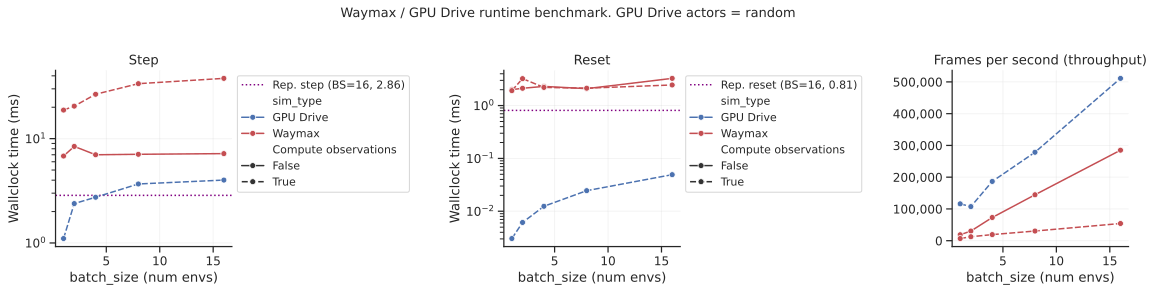

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

fig.suptitle(f'Waymax / GPU Drive runtime benchmark. GPU Drive actors = {df_gdrive_speed.actors[0]}', fontsize=13, y=1.02)   

axs[0].axhline(y=2.86, color='purple', linestyle=':', label='Rep. step (BS=16, 2.86)',)
sns.lineplot(data=df_all, x='batch_size (num envs)', y='avg_time_per_step (ms)', style='Compute observations', palette=['b', 'r'], hue='sim_type', marker='o', ax=axs[0], color='b',)
axs[0].set_yscale('log')
axs[0].set_title('Step')


axs[1].axhline(y=0.81, color='purple', linestyle=':', label='Rep. reset (BS=16, 0.81)')
axs[1].set_title('Reset')
axs[1].set_yscale('log')
sns.lineplot(data=df_all, x='batch_size (num envs)', y='avg_time_per_reset (ms)', palette=['b', 'r'], style='Compute observations', hue='sim_type', marker='o', ax=axs[1], color='b',)

axs[0].set_ylabel('Wallclock time (ms)')
axs[1].set_ylabel('Wallclock time (ms)')
axs[2].set_ylabel(' ')

sns.lineplot(data=df_all, x='batch_size (num envs)', y='all_agent_fps (throughput)', style='Compute observations', palette=['b', 'r'], hue='sim_type', marker='o', ax=axs[2], color='k', legend=False)

axs[2].set_title('Frames per second (throughput)')
axs[0].grid(True, alpha=0.2)
axs[1].grid(True, alpha=0.2)
axs[2].grid(True, alpha=0.2)
axs[2].get_yaxis().set_major_formatter(
matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

axs[0].legend(fontsize=11, loc='best', bbox_to_anchor=(1, 1))
axs[1].legend(fontsize=11, loc='best', bbox_to_anchor=(1, 1))

plt.tight_layout()
sns.despine()

### Meta data

In [6]:
df_gdrive_metadata

,sim_type,device_name,num_envs (BS),num_valid_objects_per_scene (dist)
0,Waymax,NVIDIA GeForce RTX 4080,1,13
1,Waymax,NVIDIA GeForce RTX 4080,2,"[13, 65]"
2,Waymax,NVIDIA GeForce RTX 4080,4,"[13, 65, 27, 25]"
3,Waymax,NVIDIA GeForce RTX 4080,8,"[13, 65, 27, 25, 37, 5, 20, 43]"
4,Waymax,NVIDIA GeForce RTX 4080,16,"[13, 65, 27, 25, 37, 5, 20, 43, 36, 64, 6, 8, ..."


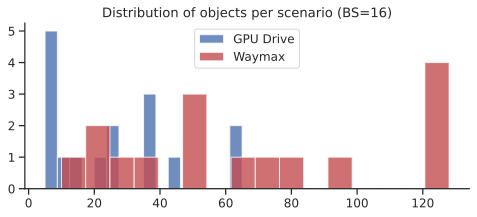

In [7]:
plt.hist(ast.literal_eval(df_gdrive_metadata[df_gdrive_metadata['num_envs (BS)'] == 16]['num_valid_objects_per_scene (dist)'].values[0]), color='b', label='GPU Drive', bins=16, alpha=0.8)
plt.hist(ast.literal_eval(df_waymax_metadata[df_waymax_metadata['num_envs (BS)'] == 16]['num_valid_objects_per_scene (dist)'].values[0]), color='r', label='Waymax', bins=16, alpha=0.8)
plt.title('Distribution of objects per scenario (BS=16)')
plt.legend()
sns.despine()

### GPU Drive conditions

- Does stepping with experts or random actors (controlling up to `max_num_objects = 128`) make a difference?

In [12]:
df_gdrive_expert = pd.read_csv('gpudrive_speed_13_1234_expert.csv') # expert-actors
df_gdrive_rand = pd.read_csv('gpudrive_speed_13_1220.csv') # random-actors

df_gdrive_cond = pd.concat([df_gdrive_expert, df_gdrive_rand])

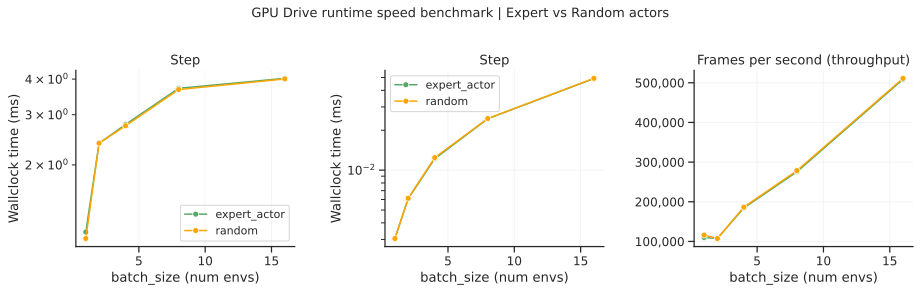

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(13, 4))

fig.suptitle('GPU Drive runtime speed benchmark | Expert vs Random actors', fontsize=13, y=1.02)

sns.lineplot(data=df_gdrive_cond, x='batch_size (num envs)', y='avg_time_per_step (ms)', palette=['g', 'orange'], hue='actors', marker='o', ax=axs[0], color='b',)
axs[0].set_yscale('log')
axs[0].set_ylabel('Wallclock time (ms)')
axs[0].set_title('Step')

sns.lineplot(data=df_gdrive_cond, x='batch_size (num envs)', y='avg_time_per_reset (ms)', palette=['g', 'orange'], hue='actors', marker='o', ax=axs[1], color='b',)
axs[1].set_yscale('log')
axs[1].set_ylabel('Wallclock time (ms)')
axs[1].set_title('Step')

sns.lineplot(data=df_gdrive_cond, x='batch_size (num envs)', y='all_agent_fps (throughput)', palette=['g', 'orange'], hue='actors', marker='o', ax=axs[2], color='k', legend=False)
axs[2].set_ylabel(' ')
axs[2].set_title('Frames per second (throughput)')

axs[0].grid(True, alpha=0.2)
axs[1].grid(True, alpha=0.2)
axs[2].grid(True, alpha=0.2)
axs[2].get_yaxis().set_major_formatter(
matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

axs[0].legend(fontsize=11, loc='best',) #bbox_to_anchor=(1, 1))
axs[1].legend(fontsize=11, loc='best',) #bbox_to_anchor=(1, 1))

plt.tight_layout()
sns.despine()

### Waymax conditions

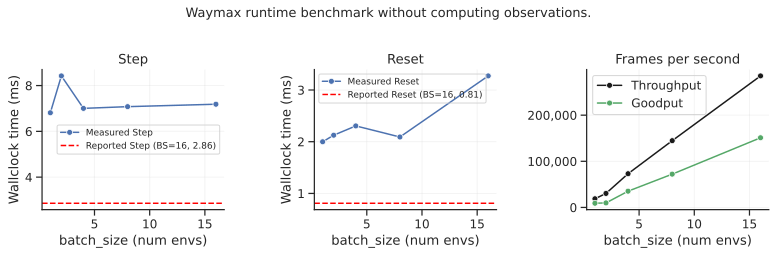

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(11, 3.5))

fig.suptitle('Waymax runtime benchmark without computing observations.', fontsize=13, y=1.02)   

sns.lineplot(data=df_waymax_speed_without_obs, x='batch_size (num envs)', y='avg_time_per_step (ms)', marker='o', ax=axs[0], color='b', label='Measured Step')
axs[0].axhline(y=2.86, color='red', linestyle='--', label='Reported Step (BS=16, 2.86)',)
axs[0].set_title('Step')

sns.lineplot(data=df_waymax_speed_without_obs, x='batch_size (num envs)', y='avg_time_per_reset (ms)', marker='o', ax=axs[1], color='b', label='Measured Reset')
axs[1].axhline(y=0.81, color='red', linestyle='--', label='Reported Reset (BS=16, 0.81)',)
axs[1].set_title('Reset')

axs[0].set_ylabel('Wallclock time (ms)')
axs[1].set_ylabel('Wallclock time (ms)')
axs[2].set_ylabel(' ')

sns.lineplot(data=df_waymax_speed_without_obs, x='batch_size (num envs)', y='all_agent_fps (throughput)', marker='o', ax=axs[2], color='k', label='Throughput')
sns.lineplot(data=df_waymax_speed_without_obs, x='batch_size (num envs)', y='val_agent_fps (goodput)', marker='o', ax=axs[2], color='g', label='Goodput')

axs[2].set_title('Frames per second')
axs[0].grid(True, alpha=0.2)
axs[1].grid(True, alpha=0.2)
axs[2].grid(True, alpha=0.2)
axs[2].get_yaxis().set_major_formatter(
matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
axs[0].legend(fontsize=9, loc='best',) #bbox_to_anchor=(1, 1))
axs[1].legend(fontsize=9, loc='best',) #bbox_to_anchor=(1, 1))

plt.tight_layout()
sns.despine()   

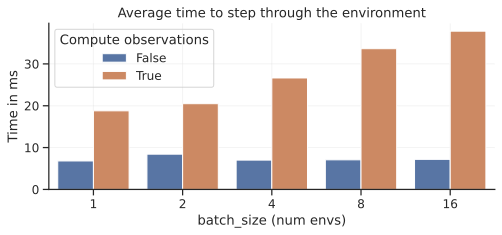

In [119]:
#df_waymax_speed[['batch_size (num envs)', 'avg_time_per_reset (ms)', 'avg_time_per_step (ms)', 'comp_obs']]

plt.title('Average time to step through the environment')
plt.ylabel('Time in ms')
sns.barplot(data=df_waymax_speed, x='batch_size (num envs)', y='avg_time_per_step (ms)', hue='Compute observations')
plt.grid(True, alpha=0.2)
sns.despine();

In [120]:
df_waymax_metadata

,sim_type,device_name,num_envs (BS),num_valid_objects_per_scene (dist)
0,Waymax,NVIDIA GeForce RTX 4080,1,[62]
1,Waymax,NVIDIA GeForce RTX 4080,2,"[62, 21]"
2,Waymax,NVIDIA GeForce RTX 4080,4,"[62, 21, 69, 95]"
3,Waymax,NVIDIA GeForce RTX 4080,8,"[62, 21, 69, 95, 128, 37, 52, 47]"
4,Waymax,NVIDIA GeForce RTX 4080,16,"[62, 21, 69, 95, 128, 37, 52, 47, 80, 128, 23,..."
